In [1]:
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# MAE: https://github.com/facebookresearch/mae
# DropPos: https://github.com/Haochen-Wang409/DropPos
# --------------------------------------------------------

import math
from functools import partial
from typing import Type, TypedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int, Bool
from src.data.components.sampling_utils import sample_and_stitch
from src.models.components.utils.part_utils import (
    compute_gt_transform,
    get_all_pairs_subset,
)
from torch import Tensor
from torch.nn.functional import mse_loss
from timm.models.vision_transformer import PatchEmbed, Block
from src.models.components.utils.pos_embed import get_2d_sincos_pos_embed


class EncoderOutput(TypedDict):
    "The output of the encoder"
    z: Float[Tensor, "B N_vis D"]

    # TODO: validate if the following shapes are correct, not sure if it's N or N_vis
    mask: Bool[Tensor, "B N"]
    "The indices of the unmasked tokens"
    ids_keep: Int[Tensor, "B N_vis"]
    ids_restore: Int[Tensor, "B ?"] # not sure what N is this
    ids_restore_pos: Int[Tensor, "B ?"] 
    "The indices of the tokens with unmasked posembeds, relative to the unmasked tokens"
    ids_keep_pos: Int[Tensor, "B N_pos"]
    "False if the position embedding "
    mask_pos: Bool[Tensor, "B N_vis"]


class DecoderOutput(TypedDict):
    pred_T: Float[Tensor, "B N_nopos**2 2"]


class LossOutput(TypedDict):
    loss: Float[Tensor, "B"]
    patch_pair_indices: Int[Tensor, "B N_nopos 2"]
    gt_T: Float[Tensor, "B N_nopos**2 2"]
    pred_T: Float[Tensor, "B N_nopos**2 2"]


class ForwardOutput(EncoderOutput, DecoderOutput, LossOutput):
    pass


class PARTMaskedAutoEncoderViT(nn.Module):
    def __init__(
        self,
        # Encoder params
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 1024,
        depth: int = 24,
        num_heads: int = 16,
        mlp_ratio: float = 4.0,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        mask_ratio: float = 0.75,
        pos_mask_ratio: float = 0.75,
        # Decoder params
        decoder_embed_dim: int = 512,
        decoder_depth: int = 8,
        decoder_num_heads: int = 16,
        num_targets: int = 2,
    ):
        super().__init__()

        # --------------------------------------------------------------------------
        self.embed_dim = embed_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.pos_mask_ratio = pos_mask_ratio
        self.num_targets = num_targets
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # fixed sin-cos embedding
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False
        )
        # mask token for position
        self.mask_pos_token = nn.Parameter(
            torch.zeros(1, 1, embed_dim), requires_grad=True
        )

        self.blocks = nn.ModuleList(
            [
                Block(
                    embed_dim,
                    num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # PART decoder specifics (w/o position embedding)
        self.decoder_embed_dim = decoder_embed_dim
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.decoder_blocks = nn.ModuleList(
            [
                Block(
                    decoder_embed_dim,
                    decoder_num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=norm_layer,
                )
                for i in range(decoder_depth)
            ]
        )

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, num_targets, bias=False
        )  # decoder to patch
        self.tanh = nn.Tanh()
        # label smoothing for positions
        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(
            self.pos_embed.shape[-1],
            int(self.patch_embed.num_patches**0.5),
            cls_token=True,
        )
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.mask_pos_token, std=0.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x: Float[Tensor, "B N D"], mask_ratio: float):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        B, N, D = x.shape  # batch, length, dim
        len_keep = int(N * (1 - mask_ratio))

        noise = torch.rand(B, N, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(
            noise, dim=1
        )  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        # remove the second subset
        ids_remove = ids_shuffle[:, len_keep:]

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([B, N], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore).bool()

        return ids_keep, mask, ids_restore, ids_remove

    def forward_encoder(
        self, x: Float[Tensor, "B C H W"], mask_ratio: float, pos_mask_ratio: float
    ) -> EncoderOutput:
        # ------------------- EMBED PATCHES w/o [cls] TOKEN -------------------
        x = self.patch_embed(x)
        B, N, D = x.shape
        # --------------------------- GENERATE MASK ---------------------------
        ids_keep, mask, ids_restore, ids_remove = self.random_masking(x, mask_ratio)

        # gather patch embeddings and position embeddings
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        pos_embed_all = self.pos_embed[:, 1:, :].data.repeat(B, 1, 1)  # w/o [cls] token
        pos_embed_vis = torch.gather(
            pos_embed_all, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D)
        ).detach()

        # random masking for position embedding
        ids_keep_pos, mask_pos, ids_restore_pos, ids_remove_pos = self.random_masking(
            x, pos_mask_ratio
        )

        # gather position embeddings
        pos_embed = torch.gather(
            pos_embed_vis, dim=1, index=ids_keep_pos.unsqueeze(-1).repeat(1, 1, D)
        )
        mask_pos_length = math.ceil(math.floor(N * (1 - mask_ratio)) * pos_mask_ratio)
        mask_pos_tokens = self.mask_pos_token.repeat(B, mask_pos_length, 1)
        pos_embed = torch.cat([pos_embed, mask_pos_tokens], dim=1)

        # restore position embeddings before adding
        pos_embed = torch.gather(
            pos_embed, dim=1, index=ids_restore_pos.unsqueeze(-1).repeat(1, 1, D)
        )

        # add position embedding w/o [cls] token
        x = x + pos_embed

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return {
            "z": x,
            "mask": mask,
            "ids_keep": ids_keep,
            "ids_restore": ids_restore,
            "mask_pos": mask_pos,
            "ids_keep_pos": ids_keep_pos,
            "ids_restore_pos": ids_restore_pos,
        }

    def forward_decoder(
        self,
        x: Float[Tensor, "B N_vis D"],
        img_size: int,
        mask_pos: Bool[Tensor, "B N_vis"],
    ) -> DecoderOutput:
        x = self.decoder_embed(x)
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        x: Float[Tensor, "B N_vis 2"] = x[:, 1:, :]  # remove CLS
        B, N_vis, C = x.shape
        # only predict pairwise transformations for visible patches with no position embeddings
        x: Float[Tensor, "B N_nopos C"] = x[mask_pos].view(B, -1, C)
        # compute pairwise differences
        x: Float[Tensor, "B N_nopos N_nopos C"] = x.unsqueeze(2) - x.unsqueeze(1)
        x: Float[Tensor, "B N_nopos**2 C"] = x.flatten(1, 2)
        x = self.tanh(x) * img_size
        return {"pred_T": x}

    def forward_loss(
        self,
        pred_T: Float[Tensor, "B N_nopos**2 2"],
        ids_nopos: Int[Tensor, "B N_vis"],
        patch_positions: Int[Tensor, "B N 2"],
        img_size: int,
    ) -> LossOutput:
        """
        Compute the loss for the model.
        :param pred_T: predicted transformations
        :param ids_nopos: indices of the visible patches without position embeddings
        :param patch_positions: positions of the patches
        :param img_size: size of the image
        """

        # only compute loss over the visible paches **without** position embeddings
        patch_pair_indices: Int[Tensor, "B N_nopos**2 2"] = get_all_pairs_subset(
            ids=ids_nopos
        )
        gt_T = compute_gt_transform(patch_pair_indices, patch_positions)
        loss = mse_loss(pred_T / img_size, gt_T / img_size)
        return {
            "loss": loss,
            "patch_pair_indices": patch_pair_indices,
            "gt_T": gt_T,
        }

    def forward(self, x: Float[Tensor, "B C H W"]) -> ForwardOutput:
        """
        :param x: image batch
        :return: ForwardOutput
        """
        out = dict()
        img_size = x.shape[-2]
        assert img_size == x.shape[-1], "Input image must be square"
        x_shuffled, patch_positions = sample_and_stitch(x, self.patch_size, "canonical")
        out |= self.forward_encoder(x_shuffled, self.mask_ratio, self.pos_mask_ratio)
        out |= self.forward_decoder(out["z"], img_size, out["mask_pos"])
        ids_nopos = out["ids_keep"][out["mask_pos"]].view(x.shape[0], -1)
        out |= self.forward_loss(out["pred_T"], ids_nopos, patch_positions, img_size)
        return out


def PART_mae_vit_base_patch16_dec512d8b(**kwargs):
    model = PARTMaskedAutoEncoderViT(
        patch_size=16,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs
    )
    return model


def patchify(
    imgs: Float[Tensor, "B C H W"], patch_size: int
) -> Float[Tensor, "B N (P^2 * C)"]:
    B, C, H, W = imgs.shape
    P = patch_size
    assert H == W and H % P == 0
    assert C == 3

    h = w = imgs.shape[2] // P
    x = imgs.reshape(shape=(B, C, h, P, w, P))
    x = torch.einsum("nchpwq->nhwpqc", x)
    x = x.reshape(shape=(B, h * w, P**2 * C))
    return x


def unpatchify(
    x: Float[Tensor, "B N (P^2 * C)"], patch_size: int
) -> Float[Tensor, "B C H W"]:
    B, N, _ = x.shape
    C = 3
    p = patch_size
    h = w = int(N**0.5)
    assert h * w == N
    x = x.reshape(shape=(B, h, w, p, p, C))
    x = torch.einsum("nhwpqc->nchpwq", x)
    imgs = x.reshape(shape=(B, C, h * p, h * p))
    return imgs


# set recommended archs
PART_mae_vit_base_patch16 = (
    PART_mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
)

# if __name__ == "__main__":
#     backbone = PART_mae_vit_base_patch16(pos_mask_ratio=0.4, mask_ratio=0.3)
#     x = torch.randn(2, 3, 224, 224)
#     # def forward(self, imgs, mask_ratio, pos_mask_ratio):
#     patch_size = 16
#     num_patches = (224 // patch_size) ** 2
#     print(backbone.patch_embed.patch_size)
#     out = backbone.forward(x)
#     print(out["loss"])
#     # compute expected loss
#     best_T = torch.zeros_like(out["gt_T"]) / 224
#     print(mse_loss(best_T, out["gt_T"] / 224))
# 

In [2]:
model = PART_mae_vit_base_patch16(pos_mask_ratio=0.4, mask_ratio=0.3).eval()
batch = torch.randn(2, 3, 224, 224)

In [3]:
with torch.no_grad():
    model(batch)

In [4]:
import hydra
from omegaconf import OmegaConf

with hydra.initialize(version_base=None, config_path="../../configs"):
    cfg = hydra.compose(
        config_name="train.yaml",
        overrides=[
            "experiment=partmae_im1k",
            "data.num_workers=0",
        ],
    )
    OmegaConf.register_new_resolver("eval", eval)
datamodule = hydra.utils.instantiate(cfg.data)
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
train_iter = iter(train_dataloader)
batch = next(train_iter)


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'train_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.
INFO:HFDataModule:Loading datasets.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:HFDataModule:Finished setting up datasets.


In [5]:
batch = batch["image"]

Running forward pass using initialization: kaiming_uniform_3
kaiming_uniform_3 tensor(0.2504)


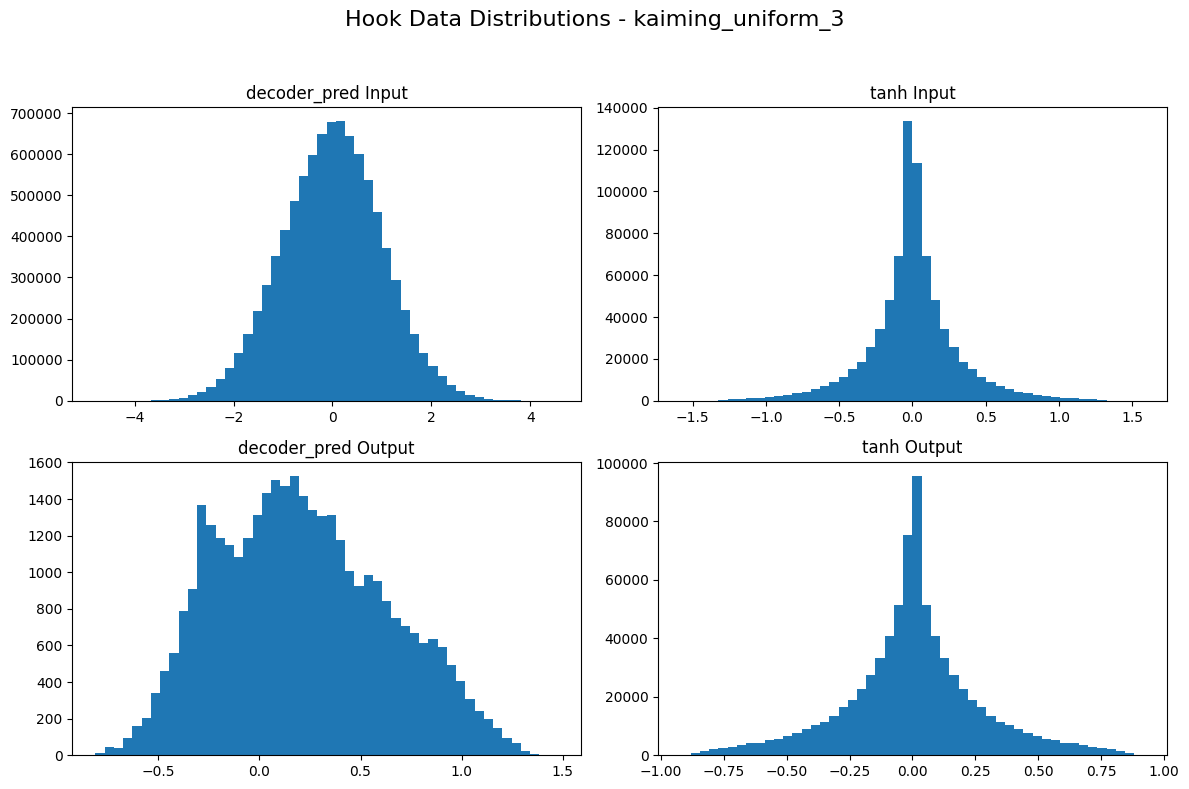

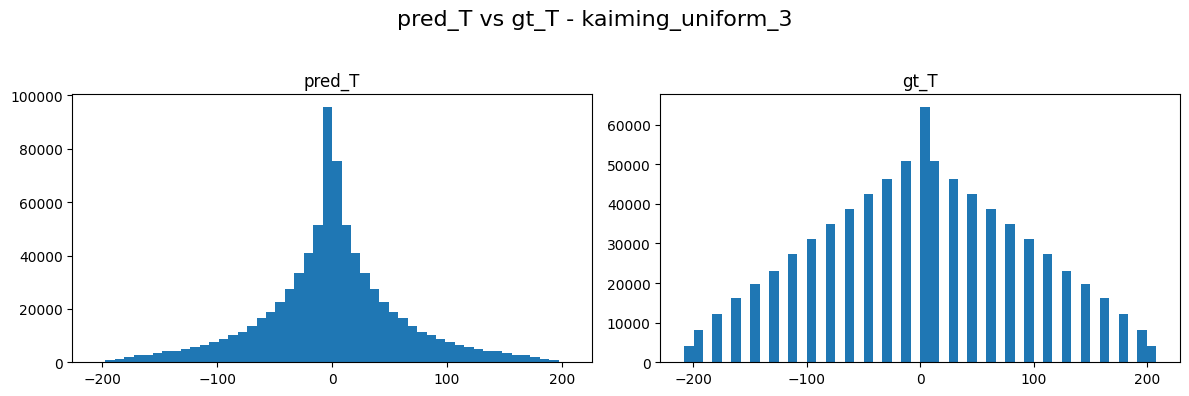

Running forward pass using initialization: kaiming_uniform_2
kaiming_uniform_2 tensor(0.2090)


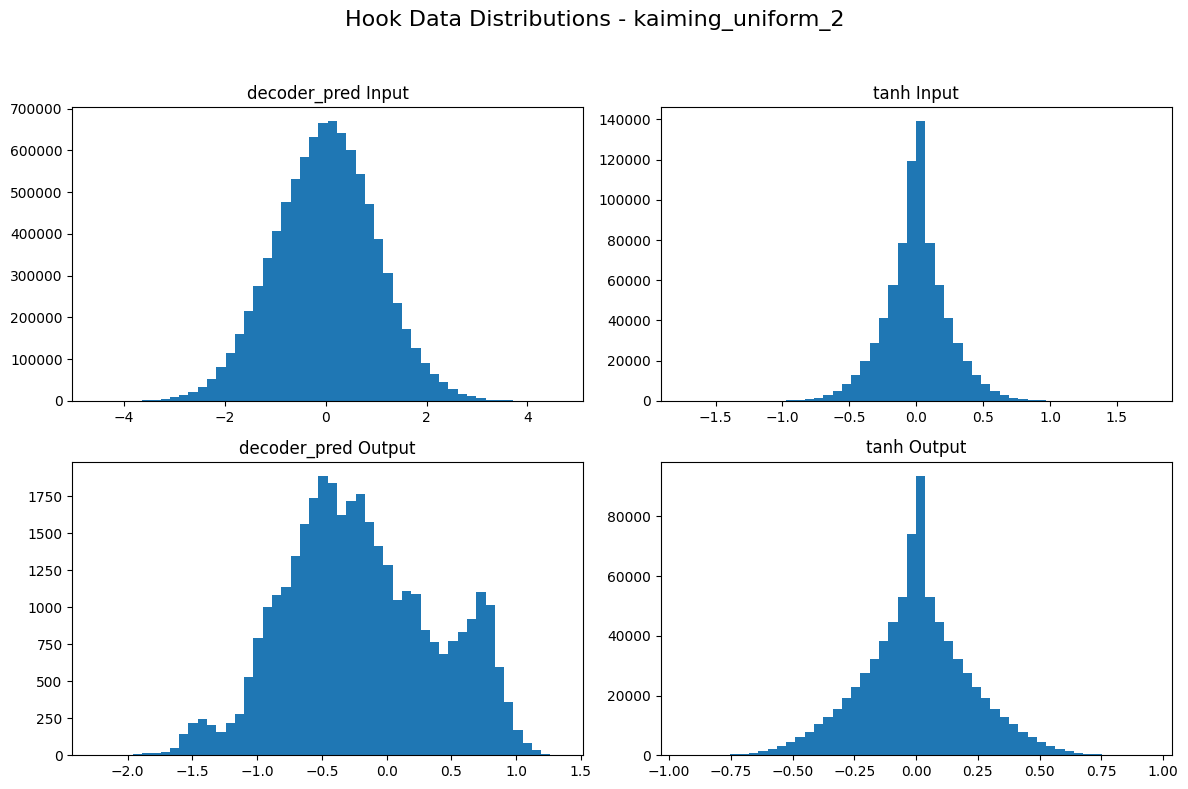

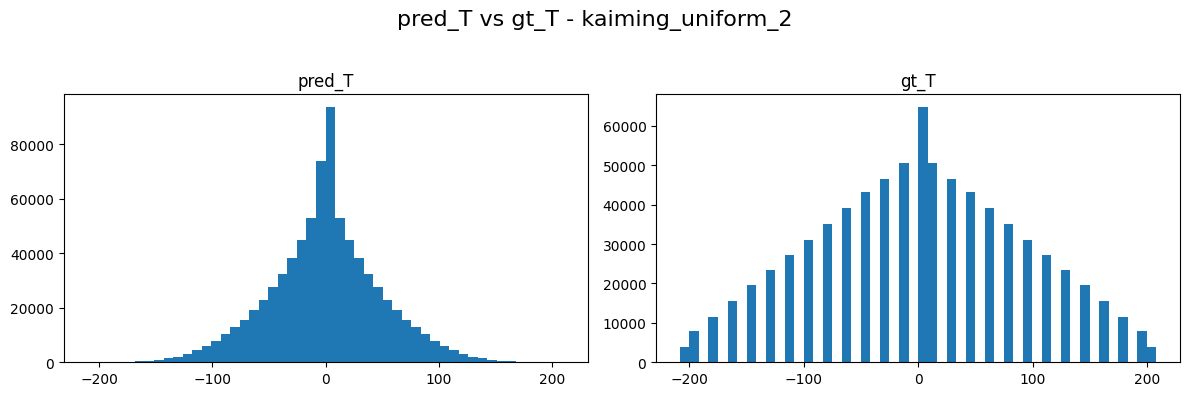

Running forward pass using initialization: kaiming_uniform_1
kaiming_uniform_1 tensor(0.3279)


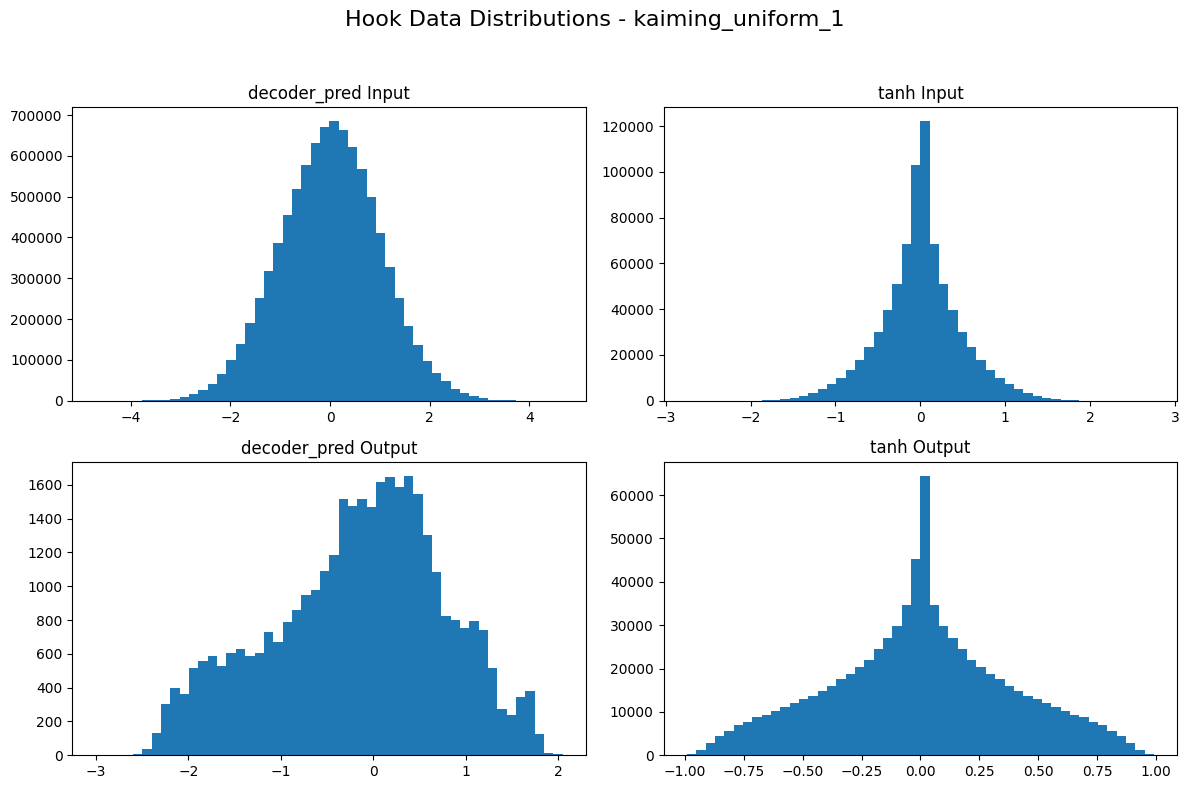

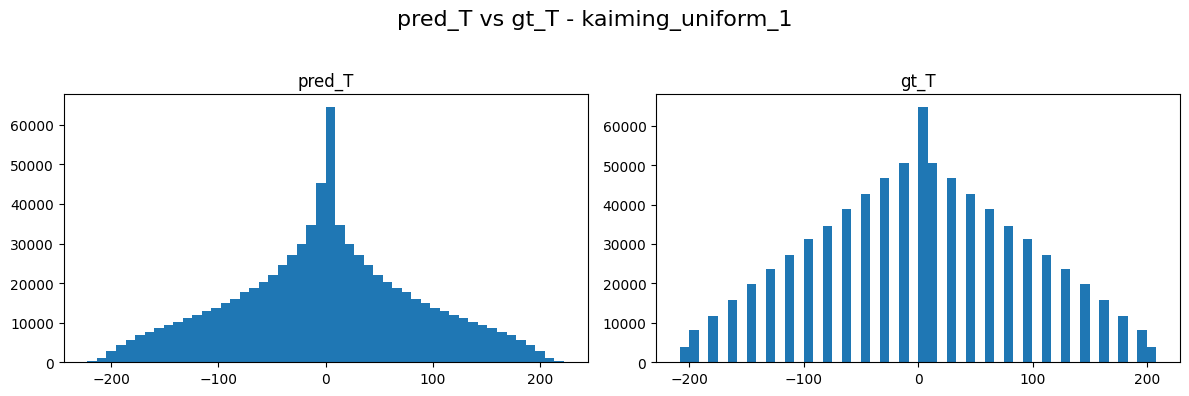

In [6]:
import matplotlib.pyplot as plt
import torch

# Dictionary to store hook data.
hook_data = {}

def get_hook(name):
    def hook(module, inputs, output):
        hook_data[name] = {
            "input": inputs[0],
            "output": output,
        }
    return hook

def plot_distributions(init_name: str, model: torch.nn.Module, batch: torch.Tensor):
    """
    Runs a forward pass with the given model and batch, captures the inputs/outputs from
    model.decoder_pred and model.tanh, then plots their histogram distributions.
    
    Args:
        init_name (str): Name of the initialization being tested.
        model (torch.nn.Module): The model to test.
        batch (torch.Tensor): Input batch for a forward pass.
    """
    # Clear any previous hook data.
    global hook_data
    hook_data = {}

    # Register hooks.
    handle_decoder_pred = model.decoder_pred.register_forward_hook(get_hook("decoder_pred"))
    handle_tanh = model.tanh.register_forward_hook(get_hook("tanh"))

    # Run a forward pass.
    with torch.no_grad():
        out = model(batch)
    
    print(init_name, out["loss"])

    # Retrieve and flatten hook data.
    dp_in  = hook_data["decoder_pred"]["input"].flatten().detach().cpu().numpy()
    dp_out = hook_data["decoder_pred"]["output"].flatten().detach().cpu().numpy()
    tanh_in  = hook_data["tanh"]["input"].flatten().detach().cpu().numpy()
    tanh_out = hook_data["tanh"]["output"].flatten().detach().cpu().numpy()

    # Plot a 2x2 grid of histograms.
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0, 0].hist(dp_in, bins=50)
    axs[0, 0].set_title("decoder_pred Input")
    axs[0, 1].hist(tanh_in, bins=50)
    axs[0, 1].set_title("tanh Input")
    axs[1, 0].hist(dp_out, bins=50)
    axs[1, 0].set_title("decoder_pred Output")
    axs[1, 1].hist(tanh_out, bins=50)
    axs[1, 1].set_title("tanh Output")
    fig.suptitle(f"Hook Data Distributions - {init_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Separately, plot histograms for pred_T and gt_T from the model's output.
    pred_T_hist = out["pred_T"].flatten().detach().cpu().numpy()
    gt_T_hist   = out["gt_T"].flatten().detach().cpu().numpy()
    fig2, axs2 = plt.subplots(1, 2, figsize=(12, 4))
    axs2[0].hist(pred_T_hist, bins=50)
    axs2[0].set_title("pred_T")
    axs2[1].hist(gt_T_hist, bins=50)
    axs2[1].set_title("gt_T")
    fig2.suptitle(f"pred_T vs gt_T - {init_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Remove hooks.
    handle_decoder_pred.remove()
    handle_tanh.remove()


# Example usage:
# Assume your model is defined and you have a valid input batch.
# For example, assuming a model instance and a dummy batch:
# model = ... 
# batch = torch.randn(2, 3, 224, 224)

# Define a dictionary of different initialization functions.
# Each function takes the model, and its purpose is to reinitialize model.decoder_pred weights.
inits = {
    "kaiming_uniform_3": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=3),
    "kaiming_uniform_2": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=2),
    "kaiming_uniform_1": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=1),
    # Add additional initialization functions here.
}

# Iterate over initializations and test.
for init_name, init_func in inits.items():
    # Reinitialize the decoder_pred weights.
    init_func(model)
    print(f"Running forward pass using initialization: {init_name}")
    plot_distributions(init_name, model, batch)